# Convolutional Neural Networks using PyTorch

### Dataset: CIFAR10
- 32x32 pixel images that classify 10 labels:
    - 0 = airplane
    - 1 = automobile
    - 2 = bird
    - 3 = cat
    - 4 = deer
    - 5 = dog
    - 6 = frog
    - 7 = horse
    - 8 = ship
    - 9 = truck

Imports

In [1]:
# Numpy
import numpy as np
import time
import matplotlib.pyplot as plt
# Import torch core functionalities
import torch
# torch neural network library
import torch.nn as nn
# Activation functions
import torch.nn.functional as F
# Optimizer to do gradient descent
import torch.optim as optim
# For stuff like data 
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms

### Step 1: Get and prepare the Data (in Pytorch Tensors)

Method 1: Manual (We won't use this for this implementation)
- Generally worse to do, but nice to get some intuition about the data

In [2]:
cifar10_data = torchvision.datasets.CIFAR10('data', train=True, download=True)

Files already downloaded and verified


Describe the data:
- each datapoint is given as a tuple of a pillow image and a label (see above)
- unpacking the pillow image gives a 3x32x32 tensor (say we call it img_tensor)
- img_tensor[0, :, :] = red intensity of each pixel, [1, :, :] = green intensity and [2, :, :] is blue

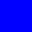

In [3]:
# img_to_tensor is initialized as a method that converts an image to a tensor
img_to_tensor = torchvision.transforms.ToTensor()
# test tensor to img
tensor_to_img = torchvision.transforms.ToPILImage()
#plt.imshow(cifar10_data[0][0])
t = img_to_tensor(cifar10_data[0][0])
t[0]

test = torch.FloatTensor(3,32,32)
test[0, :, :] = 0
test[1, :, :] = 0
test[2, :, :] = 1
test_img = tensor_to_img(test)
test_img

Key point about torch.nn.conv2d:
- we can input 4D tensors in the format: nSamples x mChannels x height x width to the convolutional layers, so for our case:
    - 50 000 training samples
    - 3 channels (RGB)
    - 32x32 images
    - need a 50 000 x 3 x 32 x 32 input tensor to the NN

In [4]:
len(cifar10_data)

50000

Prep the data in this shape:

In [5]:
# Collect tensors in a list, concatenate them using stack
X = []
y = [] # For the output we will collect the integers as a list and convert to a longtensor later

for (image, label) in cifar10_data:
    X.append(img_to_tensor(image))
    y.append(label)

X_train = torch.stack(X)
y_train = torch.LongTensor(y)

print(X_train.shape)
print(y_train.shape)


torch.Size([50000, 3, 32, 32])
torch.Size([50000])


Method 2: Use Data loading in pytorch
- Generally nicer, can load your own data too
- allows for automation of batch training`

In [6]:
img_to_tensor = torchvision.transforms.ToTensor()
train_data = torchvision.datasets.CIFAR10('data', train=True, download=True, transform=img_to_tensor)
print(train_data)
# Train data[0][0] is the img tensor for the first sample
# Train data[0][1] is the label for the first sample

test_data = torchvision.datasets.CIFAR10('data', train=False, download=True, transform=img_to_tensor)
print(test_data)

Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


Now, we want to split the training set into training data and validation data
- recall: We update the weights based on the training loss, but judge model performance based on that training on validation loss
- once weights are set, we leave them fixed and use the test set

In [7]:
# Define valid_size as a percent to split train_data
valid_size = 0.20
# Want to randomly shuffle the indices so we split training data and validation data randomly
indices = list(range(len(train_data)))
# shuffle indices list
np.random.seed(1)
np.random.shuffle(indices)
# Define split as the number of samples in the validation set according to the % split defined as valid_size
split = int(valid_size * len(train_data)) 
valid_idx, train_idx = indices[:split], indices[split:] 
# Define sampler using these indices, which will be used for data loading:
train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_idx)
valid_sampler = torch.utils.data.sampler.SubsetRandomSampler(valid_idx)


We load the data using the below block of code, which we won't run yet: we might want to tune the batch size as a hyperparameter, and we'll do that in a box below

In [ ]:
batch_size = '???'

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
valid_loader = torch.utils.data.Dataloader(train_data, batch_size=batch_size, sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

### Step 2: Understand CNN Operations

Try one layer of the NN with discussed dimensions:
- in_channels = 3 because we have 3 input channels: R,G and B
- out_Channels = 6: a hyperparameter: number of kernels/filters applied in the layer
- kernel size = 3, by convention we always use 3x3 kernels
- stride = 1
    - How the convolution is done:
        - the layer has a 3-d filter w0
        - to train on a, for example, red input: x[0, :, :], 
            - w0[0, :, :] is the 2d kernel that is applied to x[0, :, :]
            - in one iteration of convolution (i.e. one stride):
                - the layer does elementwise multiplication with the section of x[0,:,:] and w0[0,:,:], and sums everything up
                    - say we get a result $R_{red}$
                - repeat for the other channels (blue and green) to get $R_{blue}$ and $R_{green}$
                - sum ALL the products of all the channels (i.e. $R_{red} + R_{blue} + R_{green}$ )
                - add some bias term from some bias vector b0
                - that corresponds to one square of the output
                - move "left" to the next part of the image, and step equal to the stride
        - that process is repeated for each kernel (w0,w1,w2,...,b1,b2,b3,... etc.)
        - gives an output that has one dimension per kernel applied
- 'same' padding means that an amount of zeros are padded on the input so that the output retains the same dimensions

In [8]:
# grab one image
for test_x in X_train:
    break

conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3, stride=1, padding='same')
x = conv1(test_x)
x.shape


torch.Size([6, 32, 32])

As expected, we got 6 outputs from one input, with unchanged dimensions (i.e. each output retains the 32x32 original image dimensions), as expected, since we defined 6 kernels (by setting 6 out_channels), and we made the image padded enough such that it retains the same dimensions.

Note: we can input either one input (which is 3d), or a 4-D tensor into the convolutional layer.

One pooling layer:

In [9]:
pool = nn.MaxPool2d(kernel_size = 2, stride=2)
x = pool(x)
x.shape

torch.Size([6, 16, 16])

Applying max pooling, we reduce the DIMENSIONS (i.e. 32x32 -> 16x16), but not the OUTPUTS (i.e. the 6 outputs of the convolution layer fed into the pooling layer still result in 6 output). <br>

Recall that we could calculate the out dimensions for either convolution/pooling layers using the formula: <br>

$o = \frac{i+2p-k}{s} + 1$

where: <br>
- $i$ = original image dimensions before the transformation: 
    - we had a 32x32 input, so $i = 32$
- $p$ = padding
    - we don't pad the pooling layer since we want to reduce the dimensions, so $p = 0$
- $k$ = kernel dimensions
    - we inputted $k = 2$
- s = stride length
    - we inputted $s = 2$

The above parameters in the equation give $o = 16$, as expected. We could change parameters and get different dimensions, which can be calculated using the above formula. <br>

### Step 3: make the CNN Model

As discussed, we use a convolutional kernel of size 3. It was proved by the VGG CNN that all convolutions can be approximated by a 3x3 kernel.

In [10]:
conv_kernel_size = 3

The structure of the neural network (i.e. number of convolution/pooling layers and their setup) is a hyperparameter. Let's use a VGG-style CNN architecture:

- Input -> conv layer 1 w/ dropout -> conv layer 2 -> pool 1
- conv layer 3 w/ dropout -> conv layer 4 -> pool 2
- linear fully connected 1 -> linear fully connected 2 -> linear fc3 (the output layer) -> softmax -> output classification

- summary: 2 conv layers, 1 pool, repeat, output to linear -> classifier <br>
Note: in this architecture, 
- the convolution layers do not reduce dimensions: i.e. set padding = same.
- the number of kernels is constant in each of the paired conv. layers, and INCREASES the deeper you go
    - as an example: in VGG, the first 2 conv layers used 64 kernels each, then pooled, then the next layer used 128 kernels, then pooled, then next 2 used 256 kernels
    - resulted in outputs getting "thicker" but smaller

The below image visualizes the original VGG CNN, which is the inspiration for this implementation:

![VGG structure Visualized](https://www.researchgate.net/profile/Hasane-Shaik/publication/369178183/figure/fig5/AS:11431281127143024@1678957943550/VGG-Neural-Network-Architecture-Source.jpg)

Hyperparameters:

In [11]:
# Initial input = 3 (RGB)

# conv layer 1
num_filters_1 = 6
conv_stride_1 = 1

# dropout probability 1
drop1 = 0.2 

# conv layer 2
num_filters_2 = num_filters_1
conv_stride_2 = 1

# pooling 1
pool_kernel_1 = 2
pool_stride_1 = 2

# conv layer 3
num_filters_3 = 12
conv_stride_3 = 1

# dropout probability 2
drop2 = 0.2 

# conv layer 4
num_filters_4 = num_filters_3
conv_stride_4 = 1

# pooling 2
pool_kernel_2 = 2
pool_stride_2 = 2

# linear 1
linear_units_1 = 80
# linear 2
linear_units_2 = 40

# Final output = 10

# Training hyperparameters
learn_rate = 0.001
epochs = 1000 #4500
batch_size = 500

In [12]:
# test
my_conv = nn.Conv2d(in_channels=3, out_channels=num_filters_1, kernel_size=conv_kernel_size, stride=conv_stride_1, padding='same')

# grab one image
for sample in X_train:
    break

test_x = my_conv(sample)
test_x.shape


torch.Size([6, 32, 32])

The model

In [13]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        # -> current DIM of one sample: 3x32x32

        ### Section 1: first block of convolution

        # 1st layer: in channels = 3 (RGB), out channels = number of filters we defined as hyperparameter
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=num_filters_1, kernel_size=conv_kernel_size, stride=conv_stride_1, padding='same')
        self.dropout1 = nn.Dropout(drop1)
        # -> current DIM of one sample: (num_filters_1)x32x32

        # 2nd layer: in_channels = out channels of 1st layer, out_channels = num of filters we defined as hyperparameter
        self.conv2 = nn.Conv2d(in_channels=num_filters_1, out_channels=num_filters_2, kernel_size=conv_kernel_size, stride=conv_stride_2, padding='same')
        
        # -> current DIM of one sample: (num_filters_2)x32x32

        # 1st pooling layer
        self.pool1 = nn.MaxPool2d(kernel_size=pool_kernel_1, stride=pool_stride_1)

        # -> current DIM of one sample: o1 = (i+2p-k)/s + 1 = (32+2(0)-pool_kernel_1)/(pool_stride_1) + 1 = (32 - pool_kernel_1 + pool_stride_1)/(pool_stride_1)
        # o1 = (i+2p-k)/s + 1 = (32+2(0)-pool_kernel_1)/(pool_stride_1) + 1 = (32 - pool_kernel_1 + pool_stride_1)/(pool_stride_1)
        # so current dim: (num_filters_2) x (32 - pool_kernel_1 + pool_stride_1)/(pool_stride_1) x (32 - pool_kernel_1 + pool_stride_1)/(pool_stride_1)
        self.o1 = int(((32 - pool_kernel_1) / (pool_stride_1)) + 1)

        ### Section 2: second block of convolution

        # 3rd layer: in = num_filters_2, out = num_filters 3
        self.conv3 = nn.Conv2d(in_channels=num_filters_2, out_channels=num_filters_3, kernel_size=conv_kernel_size, stride=conv_stride_3, padding='same')
        self.dropout2 = nn.Dropout(drop2)
        # -> current DIM of one sample: (num_filters_3) x o1 x o1

        # 4th layer: in = num_filters_3, out = num_filters 4
        self.conv4 = nn.Conv2d(in_channels=num_filters_3, out_channels=num_filters_4, kernel_size=conv_kernel_size, stride=conv_stride_4, padding='same')

        # -> current DIM of one sample: (num_filters_4) x o1 x o1

        # second pooling
        self.pool2 = nn.MaxPool2d(kernel_size=pool_kernel_2, stride=pool_stride_2)

        # current DIM of one sample: o2 = (o1 - pool_kernel_2 + pool_stride_2)/(pool_stride_2)
        # gives: dim = num_filters_4 x o2 x o2
        self.o2 = int(((self.o1 - pool_kernel_2) / (pool_stride_2)) + 1)

        ### section 3: Linear layers
        
        # -> Current DIM of one sample: flattened to 1x(num_filters_4 x o2 x o2)

        self.fc1 = nn.Linear(num_filters_4*self.o2*self.o2, linear_units_1)

        # -> Current DIM of one sample: 1 x linear_units_1

        self.fc2 = nn.Linear(linear_units_1, linear_units_2)

        # -> Current DIM of one sample: 1 x linear_units_2

        self.out = nn.Linear(linear_units_2, 10)

        # -> Current DIM of one sample: 1 x 10
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.dropout1(x)
        x = F.relu(self.conv2(x))
        x = self.pool1(x)

        x = F.relu(self.conv3(x))
        x = self.dropout2(x)
        x = F.relu(self.conv4(x))
        x = self.pool2(x)

        # Flatten x for linear layers 
        x = x.view(-1, num_filters_4*self.o2*self.o2)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        # x = F.tanh(self.fc1(x))
        # x = F.tanh(self.fc2(x))
        # NOTE: no activation for the final output
        x = self.out(x)
        # DONT Apply softmax
        #return F.softmax(x, dim=1)
        return x

In [14]:
cnn = CNN()
cnn

CNN(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (dropout1): Dropout(p=0.2, inplace=False)
  (conv2): Conv2d(6, 6, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (dropout2): Dropout(p=0.2, inplace=False)
  (conv4): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=768, out_features=80, bias=True)
  (fc2): Linear(in_features=80, out_features=40, bias=True)
  (out): Linear(in_features=40, out_features=10, bias=True)
)

Now we can make the loss function optimizer for backpropagation:

- using a cross entropy loss criterion (note, this is conventional for multi-class classification): <br>
$ H(p, q) = -\sum_{x \epsilon classes} p(x)log q(x) $
- we'll use the Adam optimizer, which is a common industry choice since it needs minimal tuning:
    - Gets rapid convergence
    - why? incorporates Adaptive learning rate and momentum in gradient descent 

In [15]:
# Loss function optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=learn_rate)
learn_rate

0.001

### Step 4: Train the model

This time, let's track the time needed to train:

In [16]:
import time

Training here

Let's set up batch training with the Dataloader module:
- batch size is a hyperparameter inputted in the hyperparameter block above

In [17]:
# The samplers we defined above is essentially the same as shuffle=True, except we needed to use them to split training and validation
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

Visualize what this Dataloader object does:
- divides the training set by the batch size, rounded up
    - i.e. if we select batchsize = 6: the training data gets divided as 50 000 * (1-0.2) / 6 = 6666.666 = 6667 buckets/batches
        - the 1-0.2 comes because we coded above that 20% of the training data should be split into validation data 
    - stores training tensor and training label in a tuple that can be enumerated
- We train by: 
    - taking one batch at a time, 
    - making a prediction on each item in the batch
    - find the loss of the predictions on the batch to the actual labels of the batch
    - backpropagate to update weights (kernel values for convolutional layers, linear weights for fully connected layers)

In [68]:
print(len(train_loader))

80


In [69]:
for b,(X_train, y_train) in enumerate(train_loader):
    print(b)
    print(X_train.shape)
    print(y_train)
    break

0
torch.Size([500, 3, 32, 32])
tensor([8, 8, 3, 7, 7, 1, 5, 4, 3, 1, 0, 5, 4, 9, 6, 9, 9, 3, 4, 5, 2, 1, 8, 8,
        6, 8, 1, 2, 0, 7, 2, 0, 1, 3, 6, 6, 1, 3, 0, 2, 8, 0, 6, 7, 6, 8, 4, 1,
        3, 0, 4, 8, 1, 4, 1, 4, 0, 3, 8, 6, 4, 2, 9, 6, 0, 4, 2, 0, 2, 3, 3, 9,
        4, 8, 7, 8, 1, 1, 5, 6, 5, 2, 5, 2, 2, 3, 8, 0, 0, 6, 3, 2, 3, 5, 7, 5,
        9, 7, 2, 8, 5, 7, 4, 8, 9, 2, 1, 9, 8, 1, 2, 6, 0, 4, 3, 3, 7, 2, 5, 2,
        3, 3, 3, 6, 6, 1, 6, 2, 2, 5, 0, 9, 3, 7, 9, 1, 3, 8, 2, 0, 0, 3, 0, 1,
        5, 6, 3, 8, 1, 8, 2, 6, 0, 8, 3, 7, 7, 4, 3, 7, 5, 4, 0, 9, 8, 1, 5, 8,
        7, 7, 0, 3, 2, 9, 5, 0, 5, 5, 4, 7, 6, 4, 8, 7, 6, 6, 0, 6, 6, 6, 7, 6,
        7, 3, 3, 9, 9, 4, 2, 8, 1, 2, 3, 5, 6, 1, 3, 7, 1, 4, 8, 6, 3, 3, 2, 3,
        2, 8, 1, 4, 6, 1, 4, 4, 8, 5, 2, 9, 0, 7, 3, 9, 0, 7, 6, 8, 7, 7, 9, 9,
        1, 0, 5, 3, 0, 1, 8, 3, 4, 8, 1, 5, 1, 5, 5, 7, 0, 6, 7, 5, 8, 8, 0, 6,
        1, 9, 2, 3, 6, 5, 5, 0, 3, 7, 0, 8, 9, 3, 7, 0, 9, 5, 8, 8, 3, 8, 8, 8,
        7

The training loop:
- make a prediction on training set
- compute training loss and update weights using it
- keep track of the accuracy of predictions for debug/model performance/sanity
- after training (i.e. going through batches so that we cover all the training data), test on validation set
    - no weight updates here

In [70]:
start_time = time.time()

# Variables to track things
train_losses = []
valid_losses = []
# accuracy of train_corr[0] = train_corr[0]*100 / len(train_data)
train_corr = []
valid_corr = []

# Epoch loop

for i in range(epochs):
    train_corr_count = 0
    valid_corr_count = 0
    # Batch training
    for b, (X_train, y_train) in enumerate(train_loader):
        # start our batches at 1: so batch numbers are in the range [1, batchsize] instead of [0, batchsize-1]
        b += 1
        # make a prediction on the batch
        y_pred = cnn(X_train) # X_train is dimension [batch_size, 3, 32, 32], making y_pred [batchsize, 10]
        # Find the loss using the loss function
        loss = criterion(y_pred, y_train)
        # Computes the back-propagation for each parameter:
        loss.backward()
        # Applies the update for each parameter
        optimizer.step()
        # Cleanup step for Pytorch
        optimizer.zero_grad()
        
        # Keep track of the accuracy of the predictions

        # predicted class gives us the index of most probability: i.e. what class the NN predicts the img is
        predicted_class = torch.max(y_pred.data, 1)[1]
        # batch_corr_count gives us the number of correct guesses in the batch
        batch_corr_count = (predicted_class == y_train).sum()
        # add that to the total number of correct guesses in the epoch
        train_corr_count += batch_corr_count

        # Print something so we can monitor the progress of the training
        if b % int(len(train_loader) / 2) == 0:
            print(f'Epoch: {i}, Batch: {b}, Training Loss: {loss.item()}') # loss.item() = loss[0], which is the value of loss

    # Add the final epoch accuracy and loss to train acc and train losses arrays
    train_corr.append(train_corr_count)
    train_losses.append(loss)

    # test on validation set: NO WEIGHT UPDATES
    with torch.no_grad():
        for b, (X_valid, y_valid) in enumerate(valid_loader):
            y_pred = cnn(X_valid)
            predicted_class = torch.max(y_pred.data, 1)[1]
            batch_corr_count = (predicted_class == y_valid).sum()
            valid_corr_count += batch_corr_count
    # add final loss to valid_losses
    loss = criterion(y_pred, y_valid)
    valid_losses.append(loss)

    # print something to monitor the training
    print(f'Epoch: {i}, Validation Loss: {loss.item()}') # loss.item() = loss[0], which is the value of loss


end_time = time.time()
total = end_time - start_time

print(f'Training took: {total} seconds, or: {total/60} minutes!')

Epoch: 0, Batch: 40, Training Loss: 2.122230052947998
Epoch: 0, Batch: 80, Training Loss: 1.97038733959198
Epoch: 0, Validation Loss: 1.970468521118164
Epoch: 1, Batch: 40, Training Loss: 1.8442213535308838
Epoch: 1, Batch: 80, Training Loss: 1.854427695274353
Epoch: 1, Validation Loss: 1.816688060760498
Epoch: 2, Batch: 40, Training Loss: 1.7802191972732544
Epoch: 2, Batch: 80, Training Loss: 1.8112419843673706
Epoch: 2, Validation Loss: 1.714227318763733
Epoch: 3, Batch: 40, Training Loss: 1.6624163389205933
Epoch: 3, Batch: 80, Training Loss: 1.6202425956726074
Epoch: 3, Validation Loss: 1.5982654094696045
Epoch: 4, Batch: 40, Training Loss: 1.5341696739196777
Epoch: 4, Batch: 80, Training Loss: 1.5025302171707153
Epoch: 4, Validation Loss: 1.6011933088302612
Epoch: 5, Batch: 40, Training Loss: 1.554792046546936
Epoch: 5, Batch: 80, Training Loss: 1.5371434688568115
Epoch: 5, Validation Loss: 1.5391980409622192
Epoch: 6, Batch: 40, Training Loss: 1.4757146835327148
Epoch: 6, Batch: 

Plotting Losses:

Text(0, 0.5, 'Loss')

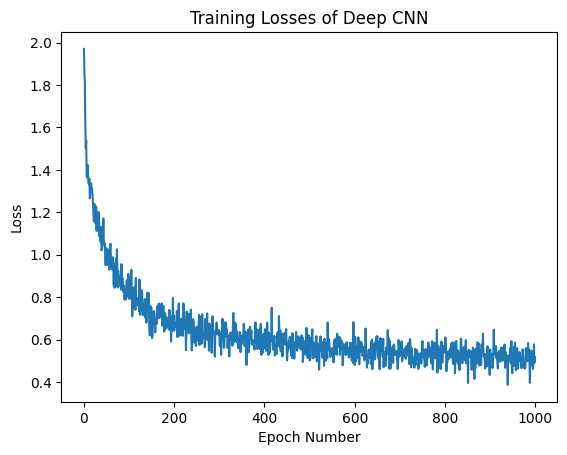

In [71]:
plt.plot(range(len(train_losses)), [x.item() for x in train_losses])
plt.title("Training Losses of Deep CNN")
plt.xlabel("Epoch Number")
plt.ylabel("Loss")

Text(0, 0.5, 'Loss')

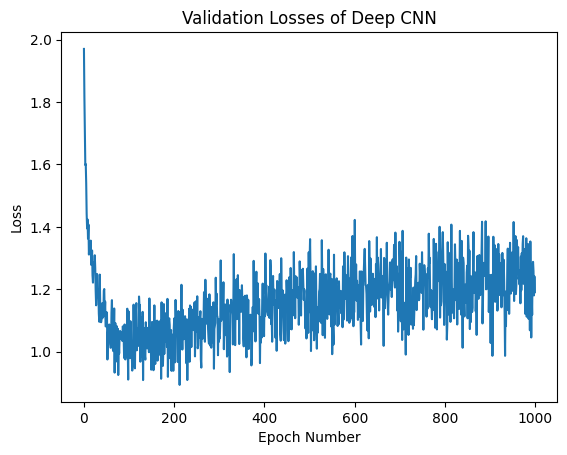

In [72]:
plt.plot(range(len(valid_losses)), [x.item() for x in valid_losses])
plt.title("Validation Losses of Deep CNN")
plt.xlabel("Epoch Number")
plt.ylabel("Loss")

Observation: loss not converging, have to tune hyperparameters:
- try greatly decreasing/increasing batch size:

In [167]:
# Training hyperparameters
learn_rate = 0.001
epochs = 100 #4500
# Greatly decrease batch size
batch_size = 5000 # was 500: this is actually quite big

# # Don't need to redefine this unless we change initial learning rate
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(cnn.parameters(), lr=learn_rate)
# learn_rate

# Don't need to redefine this unless we change batch size
# The samplers we defined above is essentially the same as shuffle=True, except we needed to use them to split training and validation
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

Now, Retrain, keeping the training we have already done:
- in Jupyter, have to keep the Python kernel open so the CNN object "cnn" retains the weights it learned

In [83]:
start_time = time.time()

# Variables to track things
train_losses = []
valid_losses = []
# accuracy of train_corr[0] = train_corr[0]*100 / len(train_data)
train_corr = []
valid_corr = []

# Epoch loop

for i in range(epochs):
    train_corr_count = 0
    valid_corr_count = 0
    # Batch training
    for b, (X_train, y_train) in enumerate(train_loader):
        # start our batches at 1: so batch numbers are in the range [1, batchsize] instead of [0, batchsize-1]
        b += 1
        # make a prediction on the batch
        y_pred = cnn(X_train) # X_train is dimension [batch_size, 3, 32, 32], making y_pred [batchsize, 10]
        # Find the loss using the loss function
        loss = criterion(y_pred, y_train)
        # Computes the back-propagation for each parameter:
        loss.backward()
        # Applies the update for each parameter
        optimizer.step()
        # Cleanup step for Pytorch
        optimizer.zero_grad()
        
        # Keep track of the accuracy of the predictions

        # predicted class gives us the index of most probability: i.e. what class the NN predicts the img is
        predicted_class = torch.max(y_pred.data, 1)[1]
        # batch_corr_count gives us the number of correct guesses in the batch
        batch_corr_count = (predicted_class == y_train).sum()
        # add that to the total number of correct guesses in the epoch
        train_corr_count += batch_corr_count

        # Print something so we can monitor the progress of the training
        if b % int(len(train_loader) / 2) == 0:
            print(f'Epoch: {i}, Batch: {b}, Training Loss: {loss.item()}') # loss.item() = loss[0], which is the value of loss

    # Add the final epoch accuracy and loss to train acc and train losses arrays
    train_corr.append(train_corr_count)
    train_losses.append(loss)

    # test on validation set: NO WEIGHT UPDATES
    with torch.no_grad():
        for b, (X_valid, y_valid) in enumerate(valid_loader):
            y_pred = cnn(X_valid)
            predicted_class = torch.max(y_pred.data, 1)[1]
            batch_corr_count = (predicted_class == y_valid).sum()
            valid_corr_count += batch_corr_count
    # add final loss to valid_losses
    loss = criterion(y_pred, y_valid)
    valid_losses.append(loss)

    # print something to monitor the training
    print(f'Epoch: {i}, Validation Loss: {loss.item()}') # loss.item() = loss[0], which is the value of loss


end_time = time.time()
total = end_time - start_time

print(f'Training took: {total} seconds, or: {total/60} minutes!')

Epoch: 0, Batch: 4, Training Loss: 0.521933913230896
Epoch: 0, Batch: 8, Training Loss: 0.5042734742164612
Epoch: 0, Validation Loss: 1.2724581956863403
Epoch: 1, Batch: 4, Training Loss: 0.4931899905204773
Epoch: 1, Batch: 8, Training Loss: 0.4853907823562622
Epoch: 1, Validation Loss: 1.1778239011764526
Epoch: 2, Batch: 4, Training Loss: 0.4855315089225769
Epoch: 2, Batch: 8, Training Loss: 0.461322546005249
Epoch: 2, Validation Loss: 1.1862319707870483
Epoch: 3, Batch: 4, Training Loss: 0.44974061846733093
Epoch: 3, Batch: 8, Training Loss: 0.4742584526538849
Epoch: 3, Validation Loss: 1.1938141584396362
Epoch: 4, Batch: 4, Training Loss: 0.4370748996734619
Epoch: 4, Batch: 8, Training Loss: 0.4451095759868622
Epoch: 4, Validation Loss: 1.1660250425338745
Epoch: 5, Batch: 4, Training Loss: 0.4383254945278168
Epoch: 5, Batch: 8, Training Loss: 0.4746823310852051
Epoch: 5, Validation Loss: 1.206008791923523
Epoch: 6, Batch: 4, Training Loss: 0.4221138656139374
Epoch: 6, Batch: 8, Trai

Text(0, 0.5, 'Loss')

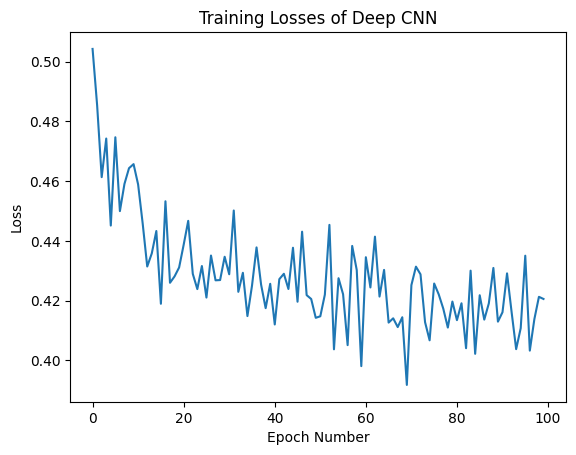

In [84]:
plt.plot(range(len(train_losses)), [x.item() for x in train_losses])
plt.title("Training Losses of Deep CNN")
plt.xlabel("Epoch Number")
plt.ylabel("Loss")

Text(0, 0.5, 'Loss')

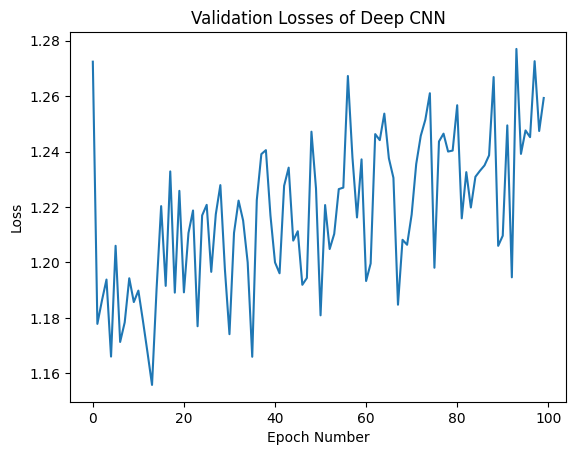

In [85]:
plt.plot(range(len(valid_losses)), [x.item() for x in valid_losses])
plt.title("Validation Losses of Deep CNN")
plt.xlabel("Epoch Number")
plt.ylabel("Loss")

The training loss is decreasing, but the validation loss is increasing:
- the model is "memorizing" the training data: the model is biased
- this means the model is overfitting
- why?
    - likely, not enough data (50,000) for the size of CNN we made
    - i.e. the CNN is too big
- maybe class distribution in training data is skewed?
    - not the case as seen below

In [111]:
classes = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}

for b, (X_train, y_train) in enumerate(train_loader):
    for item in y_train:
        for c in classes.keys():
            if c == int(item):
                classes[c] += 1

    print(classes)

{0: 486, 1: 489, 2: 505, 3: 512, 4: 484, 5: 527, 6: 474, 7: 493, 8: 501, 9: 529}
{0: 985, 1: 985, 2: 988, 3: 1048, 4: 998, 5: 1029, 6: 978, 7: 994, 8: 972, 9: 1023}
{0: 1495, 1: 1489, 2: 1496, 3: 1537, 4: 1474, 5: 1534, 6: 1457, 7: 1496, 8: 1514, 9: 1508}
{0: 2003, 1: 1953, 2: 1976, 3: 2020, 4: 1972, 5: 2062, 6: 1985, 7: 2002, 8: 2049, 9: 1978}
{0: 2487, 1: 2475, 2: 2480, 3: 2530, 4: 2477, 5: 2539, 6: 2490, 7: 2483, 8: 2549, 9: 2490}
{0: 2964, 1: 2985, 2: 2989, 3: 3022, 4: 2974, 5: 3041, 6: 2991, 7: 2989, 8: 3023, 9: 3022}
{0: 3481, 1: 3523, 2: 3458, 3: 3500, 4: 3510, 5: 3522, 6: 3508, 7: 3463, 8: 3505, 9: 3530}
{0: 4014, 1: 4014, 2: 3962, 3: 4011, 4: 3993, 5: 4005, 6: 4013, 7: 3988, 8: 4022, 9: 3978}


As can be seen: this model does not generalize!

Suggestions: 
- decrease learning rate, increase batch size
- the validation loss is noisy, but is small at some points:
    - save the weights of the iterations with the best validation loss minimization performance, and try making predictions on the test set with those three models
        - could yield decent results 
- use learning rate scheduling
    - decrease learning rate with each epoch number
- making a shallower NN
    - there might not be enough data to train a big NN: Deep NN's need lots of data


Here's how to save a model:

In [166]:
torch.save(cnn.state_dict(), 'my_model.pt')

# Load the model
my_model_loaded = CNN()
my_model_loaded.load_state_dict(torch.load("my_model.pt"))

C:\Users\brian\AppData\Local\Temp\ipykernel_32152\3797122439.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  my_model_loaded.load_state_dict(torch.load("my_model.pt"))


<All keys matched successfully>

Let's decrease learning rate and increase batch size. We'll also decrease epochs:

In [169]:
# Training hyperparameters
learn_rate = 0.0005
epochs = 100 #4500
# Greatly decrease batch size
batch_size = 5000 # was 500: this is actually quite big

# # Don't need to redefine this unless we change initial learning rate
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(cnn.parameters(), lr=learn_rate)
# learn_rate

# Don't need to redefine this unless we change batch size
# The samplers we defined above is essentially the same as shuffle=True, except we needed to use them to split training and validation
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

We will now try the same, large CNN and save the best 3 models:
- use a new instance of the CNN( i.e. discard the previous weight training, train from scratch) since we arent getting good validation loss
- scrapped this for now, we will use a smaller cnn

In [172]:
import os
import shutil

start_time = time.time()

# Variables to track things
train_losses = []
valid_losses = []
lowest_losses = [float('inf'), float('inf'), float('inf')] # each elem = ()
# accuracy of train_corr[0] = train_corr[0]*100 / len(train_data)
train_corr = []
valid_corr = []

# Epoch loop

for i in range(epochs):
    train_corr_count = 0
    valid_corr_count = 0
    # Batch training
    for b, (X_train, y_train) in enumerate(train_loader):
        # start our batches at 1: so batch numbers are in the range [1, batchsize] instead of [0, batchsize-1]
        b += 1
        # make a prediction on the batch
        y_pred = cnn(X_train) # X_train is dimension [batch_size, 3, 32, 32], making y_pred [batchsize, 10]
        # Find the loss using the loss function
        loss = criterion(y_pred, y_train)
        # Computes the back-propagation for each parameter:
        loss.backward()
        # Applies the update for each parameter
        optimizer.step()
        # Cleanup step for Pytorch
        optimizer.zero_grad()
        
        # Keep track of the accuracy of the predictions

        # predicted class gives us the index of most probability: i.e. what class the NN predicts the img is
        predicted_class = torch.max(y_pred.data, 1)[1]
        # batch_corr_count gives us the number of correct guesses in the batch
        batch_corr_count = (predicted_class == y_train).sum()
        # add that to the total number of correct guesses in the epoch
        train_corr_count += batch_corr_count

        # Print something so we can monitor the progress of the training
        if b % int(len(train_loader) / 2) == 0:
            print(f'Epoch: {i}, Batch: {b}, Training Loss: {loss.item()}') # loss.item() = loss[0], which is the value of loss

    # Add the final epoch accuracy and loss to train acc and train losses arrays
    train_corr.append(train_corr_count)
    train_losses.append(loss)

    # test on validation set: NO WEIGHT UPDATES
    with torch.no_grad():
        for b, (X_valid, y_valid) in enumerate(valid_loader):
            y_pred = cnn(X_valid)
            predicted_class = torch.max(y_pred.data, 1)[1]
            batch_corr_count = (predicted_class == y_valid).sum()
            valid_corr_count += batch_corr_count
    # add final loss to valid_losses
    loss = criterion(y_pred, y_valid)
    valid_losses.append(loss)

    # save models with highest performance

    # save cur model
    torch.save(cnn.state_dict(), 'cnnbest.pt')

    # Check if the current loss is lower than the highest of the three saved losses
    if loss < lowest_losses[0]:
        # Shift the current lowest losses
        lowest_losses = [loss, lowest_losses[0], lowest_losses[1]]
        
        # Rename files to reflect the new order of losses
        if os.path.exists("cnnbest2.pt"):
            shutil.move("cnnbest2.pt", "cnnbest3.pt")
        if os.path.exists("cnnbest1.pt"):
            shutil.move("cnnbest1.pt", "cnnbest2.pt")
        shutil.move("cnnbest.pt", "cnnbest1.pt")
    
    elif loss < lowest_losses[1]:
        # Shift the second and third lowest losses
        lowest_losses = [lowest_losses[0], loss, lowest_losses[1]]
        
        # Rename files to reflect the new order of losses
        if os.path.exists("cnnbest2.pt"):
            shutil.move("cnnbest2.pt", "cnnbest3.pt")
        shutil.move("cnnbest.pt", "cnnbest2.pt")
    
    elif loss < lowest_losses[2]:
        # Update the third lowest loss
        lowest_losses[2] = loss
        
        # Rename the file to reflect the new third lowest loss
        shutil.move("cnnbest.pt", "cnnbest3.pt")
    
    # If the current loss isn't among the top three, the temporary file "cnnbest.pt" can be removed
    else:
        os.remove("cnnbest.pt")

    # print something to monitor the training
    print(f'Epoch: {i}, Validation Loss: {loss.item()}') # loss.item() = loss[0], which is the value of loss


end_time = time.time()
total = end_time - start_time

print(f'Training took: {total} seconds, or: {total/60} minutes!')

Epoch: 0, Batch: 4, Training Loss: 0.40968531370162964
Epoch: 0, Batch: 8, Training Loss: 0.4094444215297699
Epoch: 0, Validation Loss: 1.239349126815796
Epoch: 1, Batch: 4, Training Loss: 0.4293288588523865
Epoch: 1, Batch: 8, Training Loss: 0.40665626525878906
Epoch: 1, Validation Loss: 1.2111397981643677
Epoch: 2, Batch: 4, Training Loss: 0.3954826593399048
Epoch: 2, Batch: 8, Training Loss: 0.42409542202949524
Epoch: 2, Validation Loss: 1.2398014068603516
Epoch: 3, Batch: 4, Training Loss: 0.4276799261569977
Epoch: 3, Batch: 8, Training Loss: 0.4240001440048218
Epoch: 3, Validation Loss: 1.2203418016433716
Epoch: 4, Batch: 4, Training Loss: 0.4071558713912964
Epoch: 4, Batch: 8, Training Loss: 0.39736735820770264
Epoch: 4, Validation Loss: 1.2129671573638916
Epoch: 5, Batch: 4, Training Loss: 0.4224494695663452
Epoch: 5, Batch: 8, Training Loss: 0.4326253831386566
Epoch: 5, Validation Loss: 1.2781124114990234
Epoch: 6, Batch: 4, Training Loss: 0.4167087972164154
Epoch: 6, Batch: 8,

Load the best models:

In [202]:
best1 = CNN()
best2 = CNN()
best3 = CNN()

best1.load_state_dict(torch.load("cnnbest1.pt"))
best2.load_state_dict(torch.load("cnnbest2.pt"))
best3.load_state_dict(torch.load("cnnbest3.pt"))

len(test_data)
# with torch.no_grad():
#     for X_test, y_test in e
#     y_eval1 = best3()

test_corr_count1 = 0 
test_corr_count2 = 0
test_corr_count3 = 0 

with torch.no_grad():
    for b, (X_test, y_test) in enumerate(test_loader):

        y_pred1 = best1(X_test)
        predicted_class1 = torch.max(y_pred1.data, 1)[1]
        batch_corr_count1 = (predicted_class1 == y_test).sum()
        test_corr_count1 += batch_corr_count1

        y_pred2 = best2(X_test)
        predicted_class2 = torch.max(y_pred2.data, 1)[1]
        batch_corr_count2 = (predicted_class2 == y_test).sum()
        test_corr_count2 += batch_corr_count2

        y_pred3 = best3(X_test)
        predicted_class3 = torch.max(y_pred3.data, 1)[1]
        batch_corr_count3 = (predicted_class3 == y_test).sum()
        test_corr_count3 += batch_corr_count3

print(b + 1)
print(f'accuracy of the best model: {test_corr_count1*100/len(test_data)}')
print(f'accuracy of the second-best model: {test_corr_count2*100/len(test_data)}')
print(f'accuracy of the third-best model: {test_corr_count3*100/len(test_data)}')

C:\Users\brian\AppData\Local\Temp\ipykernel_32152\1560622286.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best1.load_state_dict(torch.load("cnnbest1.pt"))
C:\Users\br

20
accuracy of the best model: 65.5999984741211
accuracy of the second-best model: 65.66999816894531
accuracy of the third-best model: 65.5999984741211


Comments: that's obviously not great

Let's design a smaller CNN:

In [31]:
class CNN2(nn.Module):
    def __init__(self):
        super().__init__()
        # DIM = 3x32x32
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3, stride=1, padding='same')
        # DIM = 6x32x32
        self.pool = nn.MaxPool2d(kernel_size=2,stride=2)
        # DIM = (32 - 2(0) - 2)/2 + 1 = 16 -> 6x16x16
        self.o = 16

        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, stride=1, padding='same')
        # DIM = 16x16x16
        # self.pool = nn.MaxPool2d(kernel_size=2,stride=2): dont need to define this here since its the same pooling layer
        # DIM = (16 - 2(0) - 2)/2 + 1 = 8 -> 16x8x8
        self.o2 = 8
        
        self.flattened_dim = self.o2*self.o2*16
        self.fc1 = nn.Linear(in_features=self.flattened_dim, out_features=100)
        self.fc2 = nn.Linear(in_features=100, out_features=50)
        self.out = nn.Linear(in_features=50, out_features=10)

        # CHANGE 1: Add 25% dropout
        self.dropout = nn.Dropout(0.25)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = x.view(-1, self.flattened_dim)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.out(x)

        return x

# AUG 18: START HERE

Redefine some hyperparameters:

In [32]:
# Training hyperparameters
learn_rate = 0.001
epochs = 1000 #4500
# Greatly decrease batch size
batch_size = 500 # was 500: this is actually quite big

In [33]:
cnn2 = CNN2()

# Loss function optimizer
criterion2 = nn.CrossEntropyLoss()
optimizer2 = torch.optim.Adam(cnn2.parameters(), lr = learn_rate)

# Don't need to redefine this unless we change batch size
# The samplers we defined above is essentially the same as shuffle=True, except we needed to use them to split training and validation
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [35]:
cnn2

CNN2(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (fc1): Linear(in_features=1024, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (out): Linear(in_features=50, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

In [36]:
for b, (X_train, y_train) in enumerate(train_loader):
    print(X_train.shape)
    print(y_train.shape)
    break

#X_train.shape
test = cnn2.forward(X_train)
#test.shape

torch.Size([500, 3, 32, 32])
torch.Size([500])


In [25]:
batch_size / len(train_loader)

6.25

In [37]:
import os
import shutil

start_time = time.time()

# Variables to track things
train_losses = []
valid_losses = []
lowest_losses = [float('inf'), float('inf'), float('inf')] # each elem = ()
# accuracy of train_corr[0] = train_corr[0]*100 / len(train_data)
train_corr = []
valid_corr = []

# Epoch loop

for i in range(epochs):
    train_corr_count = 0
    valid_corr_count = 0
    # Batch training
    for b, (X_train, y_train) in enumerate(train_loader):
        # start our batches at 1: so batch numbers are in the range [1, batchsize] instead of [0, batchsize-1]
        b += 1
        # make a prediction on the batch
        y_pred = cnn2(X_train) # X_train is dimension [batch_size, 3, 32, 32], making y_pred [batchsize, 10]
        # Find the loss using the loss function
        loss = criterion2(y_pred, y_train)
        # Computes the back-propagation for each parameter:
        loss.backward()
        # Applies the update for each parameter
        optimizer2.step()
        # Cleanup step for Pytorch
        optimizer2.zero_grad()
        
        # Keep track of the accuracy of the predictions

        # predicted class gives us the index of most probability: i.e. what class the NN predicts the img is
        predicted_class = torch.max(y_pred.data, 1)[1]
        # batch_corr_count gives us the number of correct guesses in the batch
        batch_corr_count = (predicted_class == y_train).sum()
        # add that to the total number of correct guesses in the epoch
        train_corr_count += batch_corr_count

        # Print something so we can monitor the progress of the training
        if b % int(len(train_loader) / 2) == 0:
            print(f'Epoch: {i}, Batch: {b}, Training Loss: {loss.item()}') # loss.item() = loss[0], which is the value of loss

    # Add the final epoch accuracy and loss to train acc and train losses arrays
    train_corr.append(train_corr_count)
    train_losses.append(loss)

    # test on validation set: NO WEIGHT UPDATES
    with torch.no_grad():
        for b, (X_valid, y_valid) in enumerate(valid_loader):
            y_pred = cnn2(X_valid)
            predicted_class = torch.max(y_pred.data, 1)[1]
            batch_corr_count = (predicted_class == y_valid).sum()
            valid_corr_count += batch_corr_count
    # add final loss to valid_losses
    loss = criterion2(y_pred, y_valid)
    valid_losses.append(loss)

    # save models with highest performance

    # save cur model
    torch.save(cnn2.state_dict(), 'cnnbest.pt')

    # Check if the current loss is lower than the highest of the three saved losses
    if loss < lowest_losses[0]:
        # Shift the current lowest losses
        lowest_losses = [loss, lowest_losses[0], lowest_losses[1]]
        
        # Rename files to reflect the new order of losses
        if os.path.exists("cnnbest2.pt"):
            shutil.move("cnnbest2.pt", "cnnbest3.pt")
        if os.path.exists("cnnbest1.pt"):
            shutil.move("cnnbest1.pt", "cnnbest2.pt")
        shutil.move("cnnbest.pt", "cnnbest1.pt")
    
    elif loss < lowest_losses[1]:
        # Shift the second and third lowest losses
        lowest_losses = [lowest_losses[0], loss, lowest_losses[1]]
        
        # Rename files to reflect the new order of losses
        if os.path.exists("cnnbest2.pt"):
            shutil.move("cnnbest2.pt", "cnnbest3.pt")
        shutil.move("cnnbest.pt", "cnnbest2.pt")
    
    elif loss < lowest_losses[2]:
        # Update the third lowest loss
        lowest_losses[2] = loss
        
        # Rename the file to reflect the new third lowest loss
        shutil.move("cnnbest.pt", "cnnbest3.pt")
    
    # If the current loss isn't among the top three, the temporary file "cnnbest.pt" can be removed
    else:
        os.remove("cnnbest.pt")

    # print something to monitor the training
    print(f'Epoch: {i}, Validation Loss: {loss.item()}') # loss.item() = loss[0], which is the value of loss


end_time = time.time()
total = end_time - start_time

print(f'Training took: {total} seconds, or: {total/60} minutes!')

Epoch: 0, Batch: 40, Training Loss: 2.1056039333343506
Epoch: 0, Batch: 80, Training Loss: 1.9112272262573242
Epoch: 0, Validation Loss: 1.9339944124221802
Epoch: 1, Batch: 40, Training Loss: 1.8119834661483765
Epoch: 1, Batch: 80, Training Loss: 1.8281844854354858
Epoch: 1, Validation Loss: 1.723433256149292
Epoch: 2, Batch: 40, Training Loss: 1.7408732175827026
Epoch: 2, Batch: 80, Training Loss: 1.6958447694778442
Epoch: 2, Validation Loss: 1.6198492050170898
Epoch: 3, Batch: 40, Training Loss: 1.6327643394470215
Epoch: 3, Batch: 80, Training Loss: 1.6108859777450562
Epoch: 3, Validation Loss: 1.5479726791381836
Epoch: 4, Batch: 40, Training Loss: 1.6076326370239258
Epoch: 4, Batch: 80, Training Loss: 1.5484830141067505
Epoch: 4, Validation Loss: 1.5811622142791748
Epoch: 5, Batch: 40, Training Loss: 1.5330804586410522
Epoch: 5, Batch: 80, Training Loss: 1.5736936330795288
Epoch: 5, Validation Loss: 1.5231212377548218
Epoch: 6, Batch: 40, Training Loss: 1.490497350692749
Epoch: 6, B

Text(0, 0.5, 'Loss')

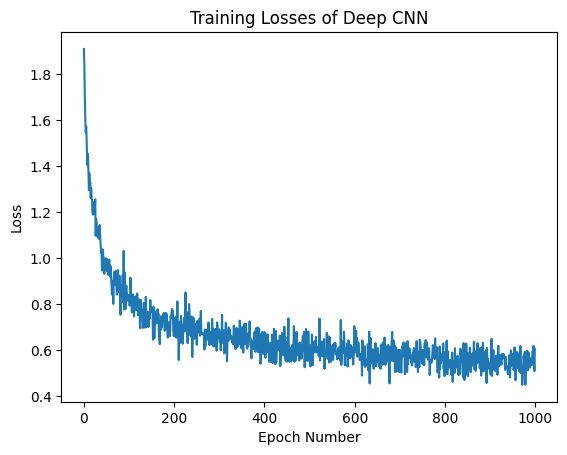

In [38]:
plt.plot(range(len(train_losses)), [x.item() for x in train_losses])
plt.title("Training Losses of Deep CNN")
plt.xlabel("Epoch Number")
plt.ylabel("Loss")

Text(0, 0.5, 'Loss')

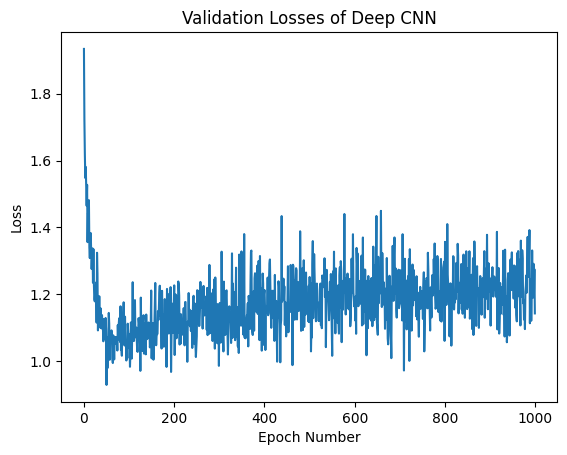

In [39]:
plt.plot(range(len(valid_losses)), [x.item() for x in valid_losses])
plt.title("Validation Losses of Deep CNN")
plt.xlabel("Epoch Number")
plt.ylabel("Loss")

In [42]:
best1 = CNN2()
best2 = CNN2()
best3 = CNN2()

best1.load_state_dict(torch.load("cnnbest1.pt"))
best2.load_state_dict(torch.load("cnnbest2.pt"))
best3.load_state_dict(torch.load("cnnbest3.pt"))

len(test_data)
# with torch.no_grad():
#     for X_test, y_test in e
#     y_eval1 = best3()

test_corr_count1 = 0 
test_corr_count2 = 0
test_corr_count3 = 0 

with torch.no_grad():
    for b, (X_test, y_test) in enumerate(test_loader):

        y_pred1 = best1(X_test)
        predicted_class1 = torch.max(y_pred1.data, 1)[1]
        batch_corr_count1 = (predicted_class1 == y_test).sum()
        test_corr_count1 += batch_corr_count1

        y_pred2 = best2(X_test)
        predicted_class2 = torch.max(y_pred2.data, 1)[1]
        batch_corr_count2 = (predicted_class2 == y_test).sum()
        test_corr_count2 += batch_corr_count2

        y_pred3 = best3(X_test)
        predicted_class3 = torch.max(y_pred3.data, 1)[1]
        batch_corr_count3 = (predicted_class3 == y_test).sum()
        test_corr_count3 += batch_corr_count3

print(b + 1)
print(f'accuracy of the best model: {test_corr_count1*100/len(test_data)}')
print(f'accuracy of the second-best model: {test_corr_count2*100/len(test_data)}')
print(f'accuracy of the third-best model: {test_corr_count3*100/len(test_data)}')

C:\Users\brian\AppData\Local\Temp\ipykernel_27780\1095478608.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best1.load_state_dict(torch.load("cnnbest1.pt"))
C:\Users\br

20
accuracy of the best model: 61.2400016784668
accuracy of the second-best model: 62.45000076293945
accuracy of the third-best model: 62.68000030517578


That's not great either
- doesnt look like the issue is with CNN architecture?

# Conclusions and future improvements
- Have to deal with model overfitting
- todo for next time:
    - evaluation/debug
        - instead of collecting number of total correct, collect number of correct for each class: can see if the model is weak at classifying some classes
        - confusion matrices
        - calculate accuracy/precision/recall
    - regularization
        - increase dropout
        - weight decay
        - early stopping patience
    - normalize the data tensors
    - try to make model generalize: implement stuff like: 
        - learning rate scheduling 
        - increase dropout
        - data augmentation
        - tweak hyperparameters (least likely to fix the issues completely since we did this)
            - increase/decrease model depth 
                - Try changing model hyperparameters
                - least likely to work since we did this 